In [211]:
IMAGE_LOC = "Zocket_real_images/07.jpg"

# Feature Extraction Mannually

### Using OCR to Extract Text


In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

In [28]:
img = cv2.imread(IMAGE_LOC)
#Alternatively: can be skipped if you have a Blackwhite image
# cv2.imshow('image',img)
# gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray, img_bin = cv2.threshold(gray,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
gray = cv2.bitwise_not(img_bin)

In [29]:
kernel = np.ones((2, 1), np.uint8)
img = cv2.erode(gray, kernel, iterations=1)
img = cv2.dilate(img, kernel, iterations=1)
text = pytesseract.image_to_string(img)


In [37]:
text 
text_sentences = text.split('\n')
text_sentences

['jrasnion',
 '',
 'upto',
 '',
 'SO%ere |',
 '',
 '‘Step out in style',
 'in statement Jackets',
 '',
 '']

### Advertisment related verbs

In [47]:
import nltk 
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

In [48]:
ad_related_dict = ['ad', 'advertisement', 'advertise', 
                   'off','sale','offer','buy','sell','purchase',
                   'discount','free','free',
                   'promo','promotional','promotion',
                   'coupon',
                   'sponcered','sponcer',
                   'shop','hurry', 'hurry up', 'hurryup', 'hurry-up', 
                   'buy now', 'buynow', 'buy-now', 'buy']

In [51]:
list_doc_stem = []
list_doc_lem = [] 

for sentence in text_sentences:
	words_stem = word_tokenize(sentence)
	words_lem = word_tokenize(sentence)
	ps = PorterStemmer()
	wl = WordNetLemmatizer()
	sentence_stem = "" 
	sentence_lem = ""
	for w in words_stem:
		rootWord_stem=ps.stem(w)
		sentence_stem += w
	
	for w in words_lem:
		rootWord=wl.lemmatize(w)
		sentence_lem += w
	if sentence_stem or sentence_lem:
		# print(f"stem = {sentence_stem}, lem = {sentence_lem}")
		list_doc_stem.append(sentence_stem)
		list_doc_lem.append(sentence_lem)

print(list_doc_stem, list_doc_lem)

['jrasnion', 'upto', 'SO%ere|', '‘Stepoutinstyle', 'instatementJackets'] ['jrasnion', 'upto', 'SO%ere|', '‘Stepoutinstyle', 'instatementJackets']


### Company name and logo search using NER

In [53]:
from clarifai_grpc.channel.clarifai_channel import ClarifaiChannel
from clarifai_grpc.grpc.api import resources_pb2, service_pb2, service_pb2_grpc
from clarifai_grpc.grpc.api.status import status_code_pb2

channel = ClarifaiChannel.get_grpc_channel()
stub = service_pb2_grpc.V2Stub(channel)


PAT = '364be188c00747a996ff66500630f444'
USER_ID = 'clarifai'
APP_ID = 'main'
MODEL_ID = 'logo-detection-v2'
MODEL_VERSION_ID = '09f3acb13bde404592c81254c5d87ae1'
# IMAGE_URL = 'https://samples.clarifai.com/metro-north.jpg'
IMAGE_FILE_LOCATION = IMAGE_LOC

metadata = (('authorization', 'Key ' + PAT),)

userDataObject = resources_pb2.UserAppIDSet(user_id=USER_ID, app_id=APP_ID)

In [54]:

# To use a local file, uncomment the following lines
with open(IMAGE_LOC, "rb") as f:
    file_bytes = f.read()

post_model_outputs_response = stub.PostModelOutputs(
    service_pb2.PostModelOutputsRequest(
        user_app_id=userDataObject,  # The userDataObject is created in the overview and is required when using a PAT
        model_id=MODEL_ID,
        version_id=MODEL_VERSION_ID,  # This is optional. Defaults to the latest model version
        inputs=[
            resources_pb2.Input(
                data=resources_pb2.Data(
                    image=resources_pb2.Image(
                        # url=IMAGE_URL
                       base64=file_bytes
                    )
                )
            )
        ]
    ),
    metadata=metadata
)
if post_model_outputs_response.status.code != status_code_pb2.SUCCESS:
    print(post_model_outputs_response.status)
    raise Exception("Post model outputs failed, status: " + post_model_outputs_response.status.description)

In [55]:
#data store for highest five confidence
# logos = dict()
logos = []
# logos['name'] = []
# logos['confidence'] = []


regions = post_model_outputs_response.outputs[0].data.regions

for region in regions:
    # Accessing and rounding the bounding box values
    top_row = round(region.region_info.bounding_box.top_row, 3)
    left_col = round(region.region_info.bounding_box.left_col, 3)
    bottom_row = round(region.region_info.bounding_box.bottom_row, 3)
    right_col = round(region.region_info.bounding_box.right_col, 3)
    
    for concept in region.data.concepts:
        # Accessing and rounding the concept value
        name = concept.name
        value = round(concept.value, 4)
        if value > 0.3:
            #store name and value in logos dict
            # logos['name'].append(name)
            # logos['confidence'].append(value)
            logos.append({name:value})
        # print((f"{name}: {value} BBox: {top_row}, {left_col}, {bottom_row}, {right_col}"))
            
logos  


[{'Harley-Davidson': 0.6217},
 {'Patagonia': 0.5388},
 {'Patagonia': 0.5132},
 {'H-M': 0.4366}]

### Product Images

In [122]:
from ultralytics import YOLO
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import cv2

model  = YOLO('yolov8n.pt') # pretrained YOLOv8n model
# frame = cv2.imread(image_location)
# results = model(frame)
# results = model.predict(image_location, conf=0.25)


In [123]:
results = model.predict(IMAGE_LOC, conf=0.3, save=False)
#store the results in variables
#make a map from string to float
# detections = dict()
detections = []
# detections['name'] = []
# detections['confidence'] = []
# Store Detection Data
boxes = results[0].boxes.xyxy.tolist()   # Store Bounding Boxes
classes = results[0].boxes.cls.tolist()  # Store classes id's
names = results[0].names                 # Store classes names
confidences = results[0].boxes.conf.tolist()  # Store Object confidence

# Iterate through the results
for box, cls, conf in zip(boxes, classes, confidences):
    x1, y1, x2, y2 = box
    confidence = conf
    detected_class = cls
    name = names[int(cls)]
    # print(f'{name}: {confidence:.2f}')
    #append this to the detections dict
    # detections['name'].append(name)
    # detections['confidence'].append(confidence)
    detections.append({name:confidence})



image 1/1 e:\LEARN\Hackathons\Zocket\Data\Wear\414852570_1040823743878887_928873364117939040_n.jpg: 640x640 2 persons, 1 clock, 406.5ms
Speed: 16.6ms preprocess, 406.5ms inference, 20.3ms postprocess per image at shape (1, 3, 640, 640)


### Color Schemas Indicative

##### DataCleaning

In [172]:
IMAGE_SIZE = 224

In [209]:
import os
from PIL import Image

# directory = "dataset/ad"

# for filename in os.listdir(directory):
#     if filename.endswith(".jpg") or filename.endswith(".png"):
#         filepath = os.path.join(directory, filename)
#         img = Image.open(filepath)
#         img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
#         img.save(filepath)

# directory = "dataset/non-ad"

# for filename in os.listdir(directory):
#     if filename.endswith(".jpg") or filename.endswith(".png"):
#         filepath = os.path.join(directory, filename)
#         img = Image.open(filepath)
#         img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
#         img.save(filepath)

directory = "Zocket_real_images"

for filename in os.listdir(directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        filepath = os.path.join(directory, filename)
        img = Image.open(filepath)
        img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
        img.save(filepath)


##### Model

In [174]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [176]:
# BATCH_SIZE = 8
# IMG_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
# directory = "dataset/"
# train_dataset = image_dataset_from_directory(directory,
#                                              shuffle=True,
#                                              batch_size=BATCH_SIZE,
#                                              image_size=IMG_SIZE,
#                                              validation_split=0.2,
#                                              subset='training',
#                                              seed=42)
# validation_dataset = image_dataset_from_directory(directory,
#                                              shuffle=True,
#                                              batch_size=BATCH_SIZE,
#                                              image_size=IMG_SIZE,
#                                              validation_split=0.2,
#                                              subset='validation',
#                                              seed=42)

Found 100 files belonging to 2 classes.
Using 80 files for training.
Found 100 files belonging to 2 classes.
Using 20 files for validation.


In [177]:
class_names = train_dataset.class_names
class_names


['Ad', 'Non-Ad']

In [178]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [179]:
# UNQ_C1
# GRADED FUNCTION: data_augmenter
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

In [180]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
assert len(augmenter.layers) == 2, "The model must have only 2 layers"


All tests passed!


In [182]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [183]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14536120/14536120 [==============================] - 5s 0us/step


In [184]:
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_10[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [185]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d_6
predictions


In [187]:
# UNQ_C2
# GRADED FUNCTION
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1)
    
    ### END CODE HERE
    
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [188]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)


9406464/9406464 [==============================] - 2s 0us/step


In [189]:
# from test_utils import summary, comparator

alpaca_summary = [['InputLayer', [(None, 160, 160, 3)], 0],
                    ['Sequential', (None, 160, 160, 3), 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['Functional', (None, 5, 5, 1280), 2257984],
                    ['GlobalAveragePooling2D', (None, 1280), 0],
                    ['Dropout', (None, 1280), 0, 0.2],
                    ['Dense', (None, 1), 1281, 'linear']] #linear is the default activation


In [190]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [191]:
initial_epochs = 10
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)


Epoch 1/5


10/10 [==============================] - 8s 309ms/step - loss: 0.8892 - accuracy: 0.5375 - val_loss: 0.6299 - val_accuracy: 0.5500
Epoch 2/5
10/10 [==============================] - 1s 137ms/step - loss: 0.7500 - accuracy: 0.6125 - val_loss: 0.4600 - val_accuracy: 0.7500
Epoch 3/5
10/10 [==============================] - 2s 168ms/step - loss: 0.5423 - accuracy: 0.7250 - val_loss: 0.4049 - val_accuracy: 0.6500
Epoch 4/5
10/10 [==============================] - 1s 139ms/step - loss: 0.4176 - accuracy: 0.7375 - val_loss: 0.3628 - val_accuracy: 0.7500
Epoch 5/5
10/10 [==============================] - 1s 132ms/step - loss: 0.3760 - accuracy: 0.8250 - val_loss: 0.2932 - val_accuracy: 0.8500


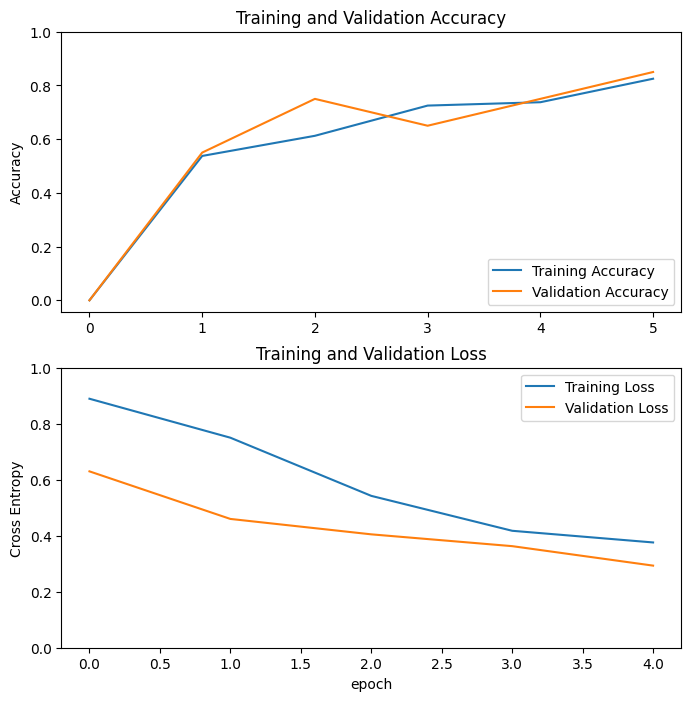

In [193]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Predictions

In [215]:
from PIL import Image
import numpy as np

image = Image.open("Zocket_real_images/My Resume Score.png")
# image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
image_array = np.array(image)

model2.predict(image_array)

ValueError: in user code:

    File "C:\Users\vivek\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\vivek\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\vivek\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\vivek\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "C:\Users\vivek\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\vivek\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 224, 4)
